In [262]:
# pyrates imports
from pyrates.ir.circuit import CircuitIR
from pyrates.backend import ComputeGraph
from pyrates.utility import plot_connectivity, create_cmap
from pyrates.frontend import CircuitTemplate

# additional imports
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['legend.fontsize'] = 20
from copy import deepcopy

%matplotlib inline

PyRates Benchmark Simulations
=============================

Below, you will find the code to run the benchmarks described in detail in "Gast, R. et al. (2018) PyRates - A Python framework for neural modeling and simulations on parallel hardware". These benchmarks consist of numerical simulations of neural population networks that differ in size and coupling density.

Benchmark parameters
--------------------

In the cell below, all important parameters of the subsequent benchmark simulations are defined. 

In [272]:
dt = 1e-3                                       # integration step-size of the forward euler solver in s
T = 1.0                                         # simulation time in s
c = 20.                                         # global connection strength scaling
N =[1, 10, 100][::-1]                           # network sizes, each of which will be run a benchmark for
p = [0.81, 0.27, 0.09, 0.03, 0.01][::-1]        # global coupling probabilities, each of which will be run a benchmark for

In [273]:
def benchmark(Ns, Ps, T, dt, init_kwargs, run_kwargs):
    """Function that will run a benchmark simulation for each combination of N and P. 
    Each benchmark simulation simulates the behavior of a neural population network, where the Jansen-Rit model is used for each of the N nodes and 
    connections are drawn randomly, such that on overall coupling density of P is established.

    Parameters
    ----------
    Ns
        Vector with network sizes.
    Ps
        Vector with coupling densities.
    T
        Overall simulation time.
    dt
        Integration step-size.
    init_kwargs
        Additional key-word arguments for the model initialization.
    run_kwargs
        Additional key-word arguments for running the simulation.

    Returns
    -------
    tuple
        Simulation times, peak memory consumptions

    """

    times = np.zeros((len(Ns), len(Ps)))
    peak_mem = np.zeros_like(times)

    for i, n in enumerate(Ns):
        for j, p in enumerate(Ps):

            print(f'Running benchmark for n = {n} and p = {p}.')
            print("Setting up the network in PyRates...")
            
            # define inter-JRC connectivity
            C = np.random.uniform(size=(n, n))
            C[C > p] = 0.
            conns = DataFrame(C, columns=[f'jrc_{idx}/PC.0/PRO.0/m_out' for idx in range(n)])
            conns.index = [f'jrc_{idx}/PC.0/RPO_e_pc.0/m_in' for idx in range(n)]

            # define input
            inp = 220 + np.random.randn(int(T / dt), n) * 22.

            # set up template
            template = CircuitTemplate.from_yaml("pyrates.examples.jansen_rit.simple_jr.JRC")

            # set up intermediate representation
            circuits = {}
            for idx in range(n):
                circuits[f'jrc_{idx}'] = deepcopy(template)
            circuit = CircuitIR.from_circuits(label='net', circuits=circuits, connectivity=conns)

            # set up compute graph
            net = ComputeGraph(circuit, dt=dt, **init_kwargs)
            
            print("Starting the benchmark simulation...")
            
            # run simulations
            _, t, m = net.run(T, inputs={('PC', 'RPO_e_pc.0', 'u'): inp}, outputs={'V': ('PC', 'PRO.0', 'PSP')},
                              verbose=False, **run_kwargs)
            times[i, j] = t
            peak_mem[i, j] = m
            
            print("Finished!")
            
    return times, peak_mem

In [274]:
results = np.zeros((len(N), len(p), 3))                       # array in which results will be stored

t, m = benchmark(N, p, T, dt, 
                 init_kwargs={'vectorization': 'full'}, 
                 run_kwargs={'profile': 'mt'})                # runs benchmark function on GPU
results[:, :, 0] = t
results[:, :, 1] = m

t, _ = benchmark(N, p, T, dt,                                 # runs benchmark function on CPU
                 init_kwargs={'vectorization': 'full'}, 
                 run_kwargs={'profile': 't'})
results[:, :, 3] = t

Running benchmark for n = 100 and p = 0.01.
connectivity setup
...finished after 0.0013494491577148438 seconds.
Frontend template setup
...finished after 5.984306335449219e-05 seconds.
IR setup
...finished after 0.23457717895507812 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.51202392578125 seconds.
...finished after 0.8812777996063232 seconds.
Running benchmark for n = 100 and p = 0.03.
connectivity setup
...finished after 0.0007715225219726562 seconds.
Frontend template setup
...finished after 3.075599670410156e-05 seconds.
IR setup
...finished after 0.23082685470581055 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.5408420562744141 seconds.
...finished after 1.1210064888000488 seconds.
Running benchmark for n = 100 and p = 0.09.
connectivity setup
...finished after 0.0007162094116210938 s

...finished after 0.31781864166259766 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.7449393272399902 seconds.
...finished after 1.083223819732666 seconds.
Running benchmark for n = 100 and p = 0.81.
connectivity setup
...finished after 0.0009169578552246094 seconds.
Frontend template setup
...finished after 3.695487976074219e-05 seconds.
IR setup
...finished after 0.39157652854919434 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.8504068851470947 seconds.
...finished after 1.424910306930542 seconds.
Running benchmark for n = 10 and p = 0.01.
connectivity setup
...finished after 0.0005452632904052734 seconds.
Frontend template setup
...finished after 3.337860107421875e-05 seconds.
IR setup
...finished after 0.03066420555114746 seconds.
Compute graph setup
moving edge operators to nodes...
chec

...finished after 0.5401873588562012 seconds.
Running benchmark for n = 10 and p = 0.09.
connectivity setup
...finished after 0.0005362033843994141 seconds.
Frontend template setup
...finished after 3.504753112792969e-05 seconds.
IR setup
...finished after 0.029050111770629883 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.021363496780395508 seconds.
...finished after 0.3349947929382324 seconds.
Running benchmark for n = 10 and p = 0.27.
connectivity setup
...finished after 0.0005388259887695312 seconds.
Frontend template setup
...finished after 3.504753112792969e-05 seconds.
IR setup
...finished after 0.03007364273071289 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.02111959457397461 seconds.
...finished after 0.3290519714355469 seconds.
Running benchmark for n = 10 and p = 0.81.
connectivit

Benchmark results visualization
-------------------------------

In the first cell below, the colormaps for plotting are defined.
In the second cell below, heatmaps are created that show the simulation time, peak memory consumption and simulation time difference between GPU and CPU for each combination of network size N and coupling density p.

In [275]:
# create colormaps
n_colors = 16
cm_red = create_cmap('pyrates_red', as_cmap=True, n=n_colors)
cm_green = create_cmap('pyrates_green', as_cmap=True, n=n_colors)
cm_div = create_cmap('pyrates_blue/pyrates_yellow', as_cmap=True, n=n_colors, reverse=True)

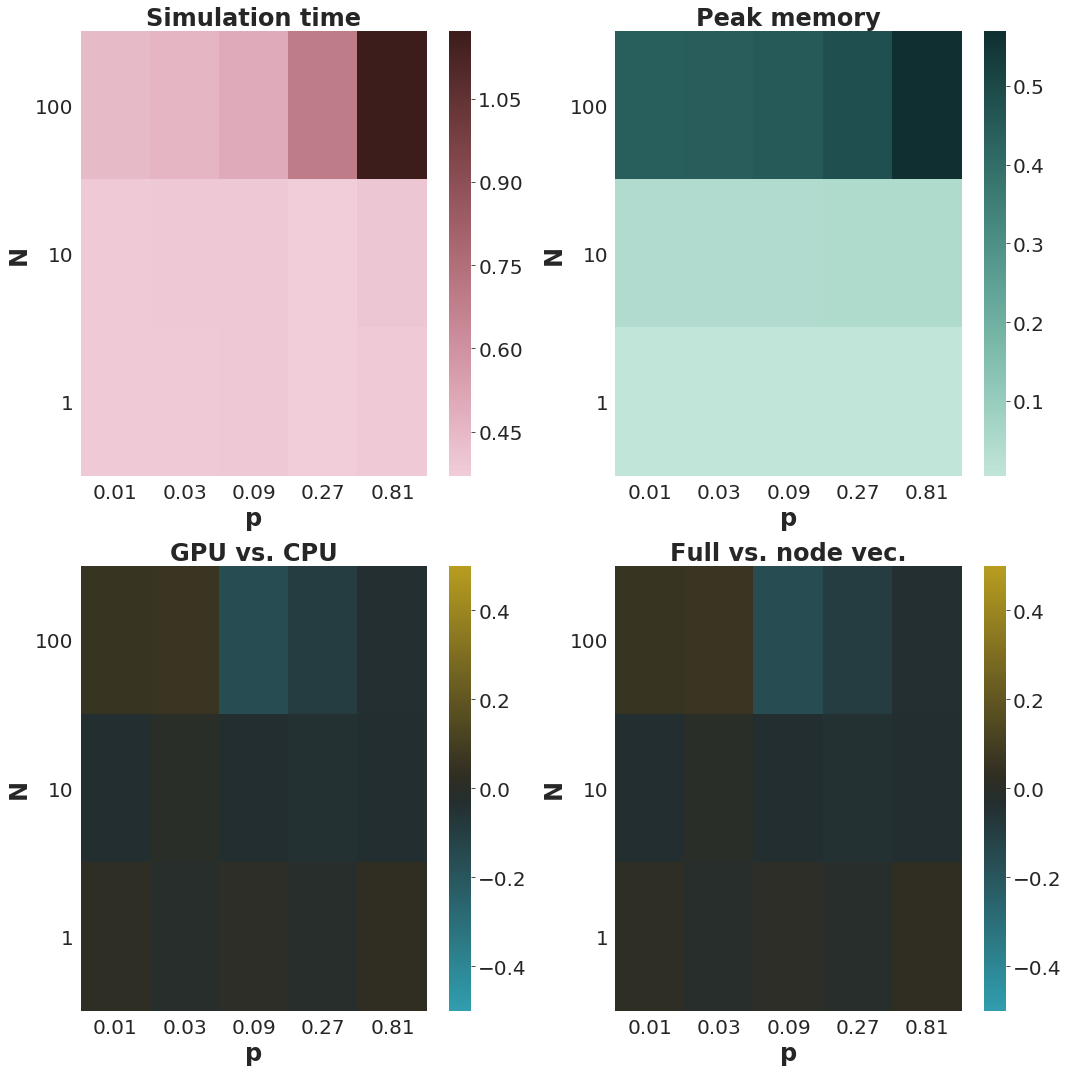

In [276]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 7))

# plot simulation times of benchmarks run on the GPU
plot_connectivity(results[:, :, 0], ax=axes[0], yticklabels=N, xticklabels=p, cmap=cm_red)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation='horizontal')
axes[0].set_ylabel('number of JRCs', labelpad=15.)
axes[0].set_xlabel('coupling density', labelpad=15.)
axes[0].set_title('Simulation time T in s', pad=20.)

# plot memory consumption of benchmarks run on the GPU
plot_connectivity(results[:, :, 1], ax=axes[1], yticklabels=N, xticklabels=p, cmap=cm_green)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation='horizontal')
axes[1].set_ylabel('number of JRCs', labelpad=15.)
axes[1].set_xlabel('coupling density', labelpad=15.)
axes[1].set_title('Peak memory in MB', pad=20.)

# plot simulation time differene between GPU and CPU
plot_connectivity(results[:, :, 2] - results[:, :, 0], ax=axes[2], yticklabels=N, xticklabels=p, cmap=cm_div)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation='horizontal')
axes[2].set_ylabel('number of JRCs', labelppad=15.)
axes[2].set_xlabel('coupling density', labelpad=15.)
axes[2].set_title(r'$\mathbf{T_{CPU}} - \mathbf{T_{CPU}}$', pad=20.)

plt.tight_layout()
#plt.savefig('/img/Gast_2018_PyRates_benchmarks.svg', format='svg')